<a href="https://www.kaggle.com/code/hamidmofidi/dm-fid?scriptVersionId=141609172" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [12]:
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision
import math
import matplotlib.pyplot as plt
import torch
import urllib
import numpy as np
import PIL

In [13]:
device = torch.device("cuda:0")

In [14]:
def get_sample_image()-> PIL.Image.Image:
    url = 'https://austerityphoto.co.uk/wp-content/uploads/2022/09/a-photo-of-a-corgi-dog-riding-a-bike-in-times-square.jpg'
    filename = 'racoon.jpg'
    urllib.request.urlretrieve(url, filename) # it download the image from the specified URL 
                                              # and save it with the given filename.
    return PIL.Image.open(filename)

In [15]:
def plot_noise_distribution(noise, predicted_noise):
    plt.hist(noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "ground truth noise")
    plt.hist(predicted_noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "predicted noise")
    plt.legend()
    plt.show()

In [16]:
def plot_noise_prediction(noise, predicted_noise):
    plt.figure(figsize=(15,15))
    f, ax = plt.subplots(1, 2, figsize = (5,5))
    ax[0].imshow(reverse_transform(noise))
    ax[0].set_title(f"ground truth noise", fontsize = 10)
    ax[1].imshow(reverse_transform(predicted_noise))
    ax[1].set_title(f"predicted noise", fontsize = 10)
    plt.show()

In [17]:
class DiffusionModel:
    def __init__(self, start_schedule=0.0001, end_schedule=0.02, timesteps = 300):
        self.start_schedule = start_schedule
        self.end_schedule = end_schedule
        self.timesteps = timesteps
        
        """
        if 
            betas = [0.1, 0.2, 0.3, ...]
        then
            alphas = [0.9, 0.8, 0.7, ...]
            alphas_cumprod = [0.9, 0.9 * 0.8, 0.9 * 0.8 * 0.7, ...]
            
        
        """ 
        self.betas = torch.linspace(start_schedule, end_schedule, timesteps)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        
    def forward(self, x_0, t, device):
        """
        x_0: (B, C, H, W)
        t: (B,)
        """
        noise = torch.randn_like(x_0)
        sqrt_alphas_cumprod_t = self.get_index_from_list(self.alphas_cumprod.sqrt(), t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x_0.shape)

        mean = sqrt_alphas_cumprod_t.to(device) * x_0.to(device)
        variance = sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)
        
        return mean + variance, noise.to(device)
    
    @torch.no_grad()
    def backward(self, x, t, model, **kwargs):
        """
        Calls the model to predict the noise in the image and returns 
        the denoised image. 
        Applies noise to this image, if we are not in the last step yet.
        """
        betas_t = self.get_index_from_list(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x.shape)
        sqrt_recip_alphas_t = self.get_index_from_list(torch.sqrt(1.0 / self.alphas), t, x.shape)
        mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t, **kwargs) / sqrt_one_minus_alphas_cumprod_t)
        posterior_variance_t = betas_t

        if t == 0:
            return mean
        else:
            noise = torch.randn_like(x)
            variance = torch.sqrt(posterior_variance_t) * noise 
            return mean + variance
    

    @staticmethod
    def get_index_from_list(values, t, x_shape):
        batch_size = t.shape[0]
        """
        pick the values from vals
        according to the indices stored in `t`
        """
        result = values.gather(-1, t.cpu())
        """
        if 
        x_shape = (5, 3, 64, 64)
            -> len(x_shape) = 4
            -> len(x_shape) - 1 = 3
            
        and thus we reshape `out` to dims
        (batch_size, 1, 1, 1)
        
        """
        return result.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


In [18]:
IMAGE_SHAPE = (32, 32)

In [19]:
transform = transforms.Compose([
    transforms.Resize(IMAGE_SHAPE), # Resize the input image
    transforms.ToTensor(), # Convert to torch tensor (scales data into [0,1])
    transforms.Lambda(lambda t: (t * 2) - 1), # Scale data between [-1, 1] 
])


reverse_transform = transforms.Compose([
    transforms.Lambda(lambda t: (t + 1) / 2), # Scale data between [0,1]
    transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
    transforms.Lambda(lambda t: t * 255.), # Scale data between [0.,255.]
    transforms.Lambda(lambda t: t.cpu().numpy().astype(np.uint8)), # Convert into an uint8 numpy array
    transforms.ToPILImage(), # Convert to PIL image
])

In [20]:
pil_image = get_sample_image()
torch_image = transform(pil_image)

In [21]:
diffusion_model = DiffusionModel()

<Figure size 1500x1500 with 0 Axes>

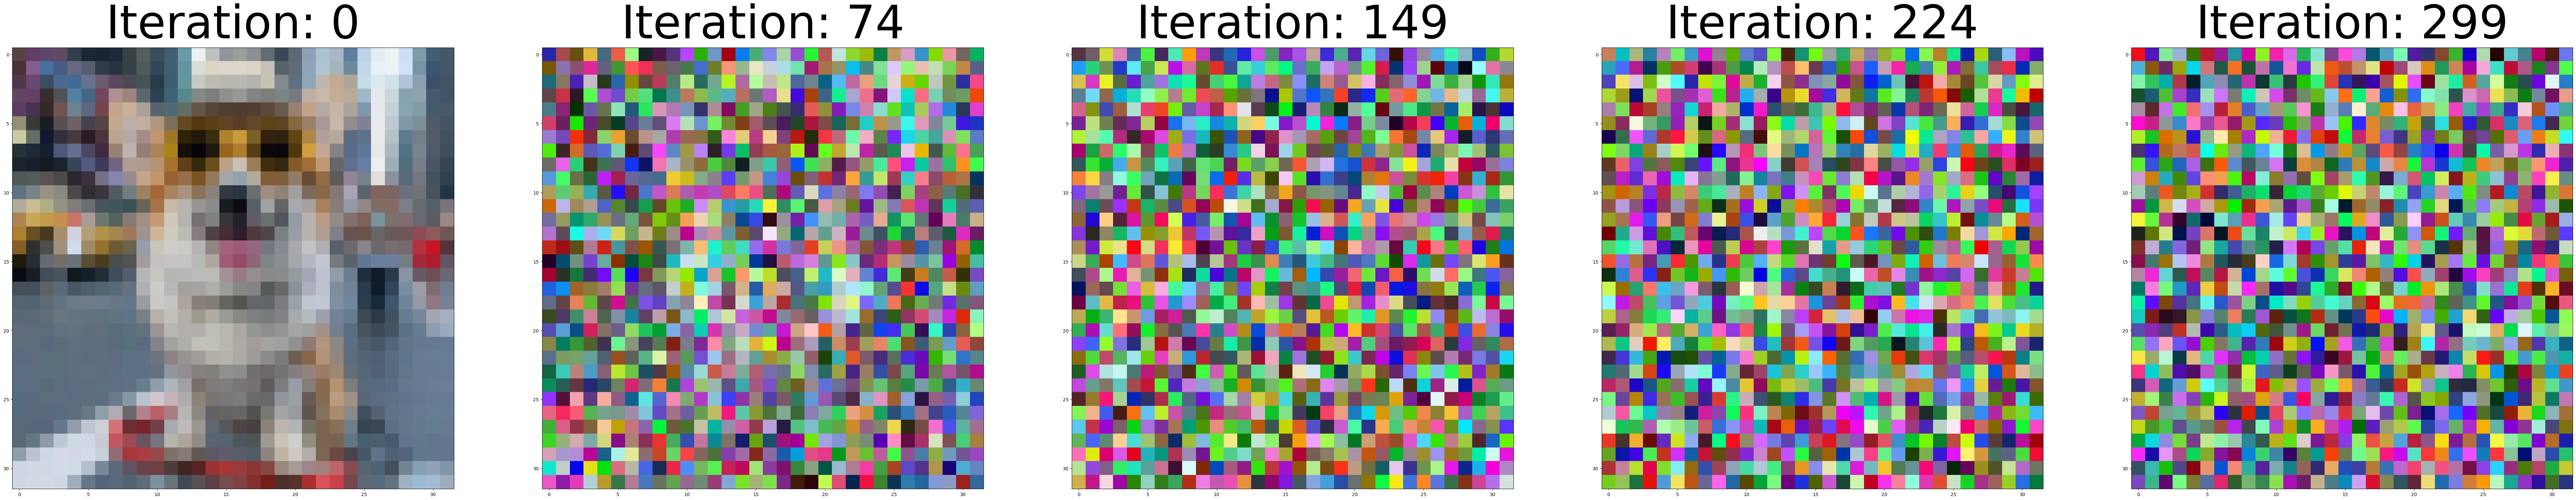

In [22]:
NO_DISPLAY_IMAGES = 5
torch_image_batch = torch.stack([torch_image] * NO_DISPLAY_IMAGES)
t = torch.linspace(0, diffusion_model.timesteps - 1, NO_DISPLAY_IMAGES).long()
noisy_image_batch, _ = diffusion_model.forward(torch_image_batch, t, device)

plt.figure(figsize=(15,15))
f, ax = plt.subplots(1, NO_DISPLAY_IMAGES, figsize = (100,100))

for idx, image in enumerate(noisy_image_batch):
    ax[idx].imshow(reverse_transform(image))
    ax[idx].set_title(f"Iteration: {t[idx].item()}", fontsize = 100)
plt.show()  

In [23]:
device

device(type='cuda', index=0)

In [24]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [25]:
class Block(nn.Module):
    def __init__(self, channels_in, channels_out, time_embedding_dims, labels, num_filters = 3, downsample=True):
        super().__init__()
        
        self.time_embedding_dims = time_embedding_dims
        self.time_embedding = SinusoidalPositionEmbeddings(time_embedding_dims)
        self.labels = labels
        if labels:
            self.label_mlp = nn.Linear(1, channels_out)
        
        self.downsample = downsample
        
        if downsample:
            self.conv1 = nn.Conv2d(channels_in, channels_out, num_filters, padding=1)
            self.final = nn.Conv2d(channels_out, channels_out, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(2 * channels_in, channels_out, num_filters, padding=1)
            self.final = nn.ConvTranspose2d(channels_out, channels_out, 4, 2, 1)
            
        self.bnorm1 = nn.BatchNorm2d(channels_out)
        self.bnorm2 = nn.BatchNorm2d(channels_out)
        
        self.conv2 = nn.Conv2d(channels_out, channels_out, 3, padding=1)
        self.time_mlp = nn.Linear(time_embedding_dims, channels_out)
        self.relu = nn.ReLU()

    def forward(self, x, t, **kwargs):
        o = self.bnorm1(self.relu(self.conv1(x)))
        o_time = self.relu(self.time_mlp(self.time_embedding(t)))
        o = o + o_time[(..., ) + (None, ) * 2]
        if self.labels:
            label = kwargs.get('labels')
            o_label = self.relu(self.label_mlp(label))
            o = o + o_label[(..., ) + (None, ) * 2]
            
        o = self.bnorm2(self.relu(self.conv2(o)))

        return self.final(o)    

In [26]:
class UNet(nn.Module):
    def __init__(self, img_channels = 3, time_embedding_dims = 128, labels = False, sequence_channels = (64, 128, 256, 512, 1024)):
        super().__init__()
        self.time_embedding_dims = time_embedding_dims
        sequence_channels_rev = reversed(sequence_channels)
        
        self.downsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels) for channels_in, channels_out in zip(sequence_channels, sequence_channels[1:])])
        self.upsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels,downsample=False) for channels_in, channels_out in zip(sequence_channels[::-1], sequence_channels[::-1][1:])])
        self.conv1 = nn.Conv2d(img_channels, sequence_channels[0], 3, padding=1)
        self.conv2 = nn.Conv2d(sequence_channels[0], img_channels, 1)

    
    def forward(self, x, t, **kwargs):
        residuals = []
        o = self.conv1(x)
        for ds in self.downsampling:
            o = ds(o, t, **kwargs)
            residuals.append(o)
        for us, res in zip(self.upsampling, reversed(residuals)):
            o = us(torch.cat((o, res), dim=1), t, **kwargs)
            
        return self.conv2(o)

In [27]:
NO_EPOCHS = 2000
PRINT_FREQUENCY = 400
LR = 0.001
BATCH_SIZE = 128
VERBOSE = True

unet = UNet(labels=False)
unet.to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

---
Epoch: 0 | Train Loss 1.0359256267547607


<Figure size 1500x1500 with 0 Axes>

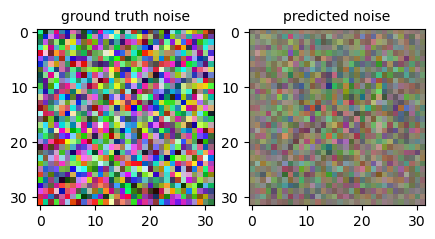

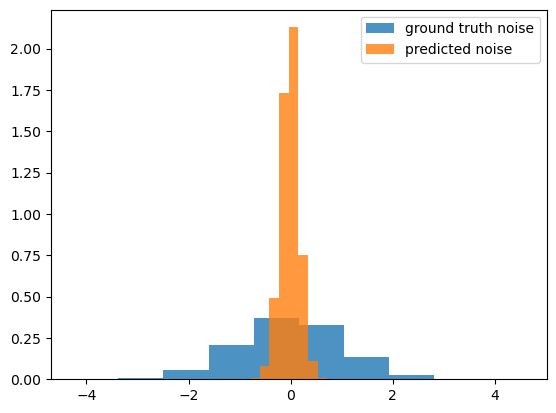

---
Epoch: 400 | Train Loss 0.02560081146657467


<Figure size 1500x1500 with 0 Axes>

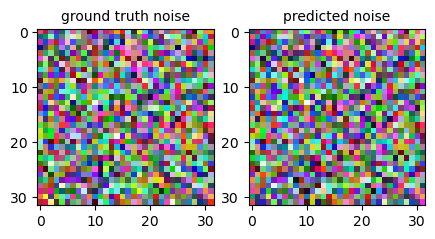

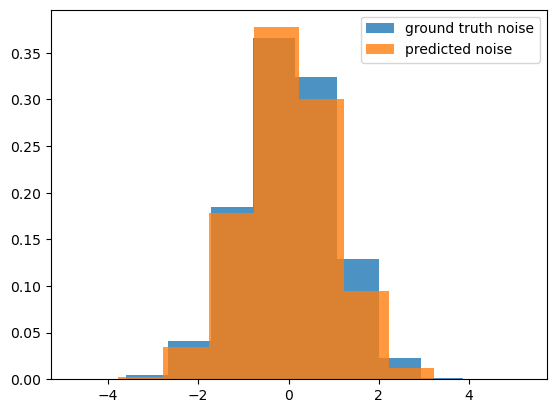

---
Epoch: 800 | Train Loss 0.013773193582892418


<Figure size 1500x1500 with 0 Axes>

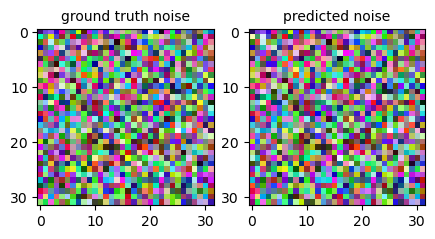

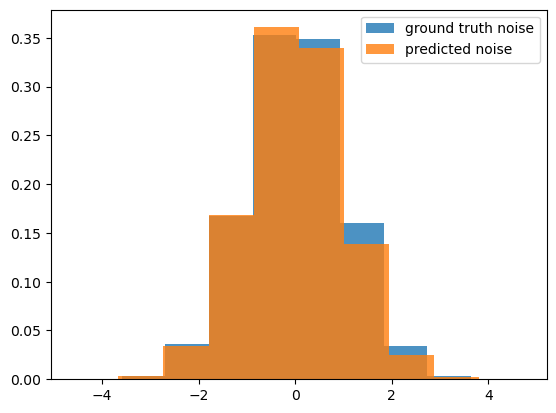

---
Epoch: 1200 | Train Loss 0.00844685360789299


<Figure size 1500x1500 with 0 Axes>

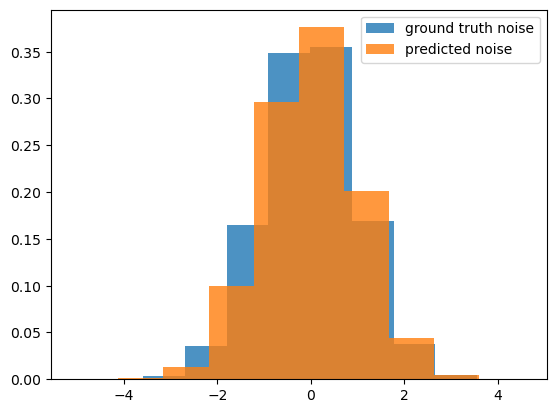

---
Epoch: 1600 | Train Loss 0.0070753879845142365


<Figure size 1500x1500 with 0 Axes>

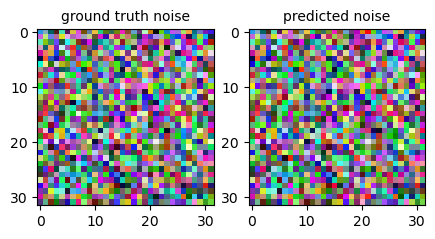

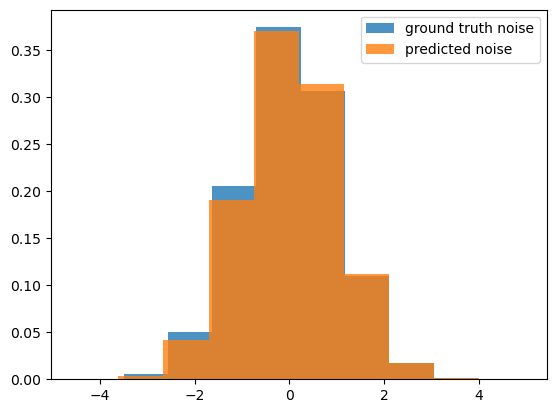

In [28]:
for epoch in range(NO_EPOCHS):
    mean_epoch_loss = []
    
    batch = torch.stack([torch_image] * BATCH_SIZE)
    t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)

    batch_noisy, noise = diffusion_model.forward(batch, t, device) 
    predicted_noise = unet(batch_noisy, t)
    
    optimizer.zero_grad()
    loss = torch.nn.functional.mse_loss(noise, predicted_noise) 
    mean_epoch_loss.append(loss.item())
    loss.backward()
    optimizer.step()
    
    if epoch % PRINT_FREQUENCY == 0:
        print('---')
        print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)}")
        if VERBOSE:
            with torch.no_grad():
                plot_noise_prediction(noise[0], predicted_noise[0])
                plot_noise_distribution(noise, predicted_noise)

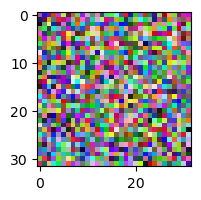

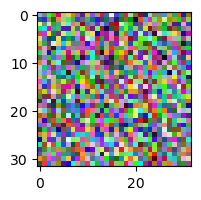

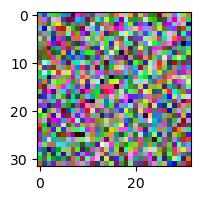

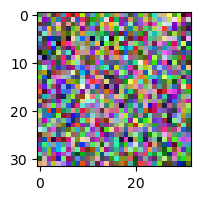

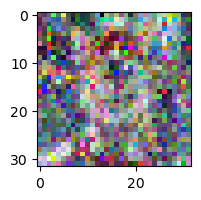

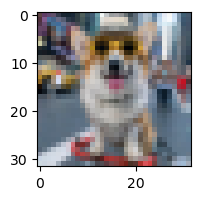

In [29]:
with torch.no_grad():
    img = torch.randn((1, 3) + IMAGE_SHAPE).to(device)
    for i in reversed(range(diffusion_model.timesteps)):
        t = torch.full((1,), i, dtype=torch.long, device=device)
        img = diffusion_model.backward(img, t, unet.eval())
        if i % 50 == 0:
            plt.figure(figsize=(2,2))
            plt.imshow(reverse_transform(img[0]))
            plt.show()

In [30]:
BATCH_SIZE = 256
NO_EPOCHS = 100
PRINT_FREQUENCY = 10
LR = 0.001
VERBOSE = False

unet = UNet(labels=True)
unet.to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

In [31]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, drop_last=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, drop_last=True)

Files already downloaded and verified


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


In [ ]:
for epoch in range(NO_EPOCHS):
    mean_epoch_loss = []
    mean_epoch_loss_val = []
    for batch, label in trainloader:
        t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)
        batch = batch.to(device)
        batch_noisy, noise = diffusion_model.forward(batch, t, device) 
        predicted_noise = unet(batch_noisy, t, labels = label.reshape(-1,1).float().to(device))

        optimizer.zero_grad()
        loss = torch.nn.functional.mse_loss(noise, predicted_noise) 
        mean_epoch_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
    for batch, label in testloader:

        t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)
        batch = batch.to(device)

        batch_noisy, noise = diffusion_model.forward(batch, t, device) 
        predicted_noise = unet(batch_noisy, t, labels = label.reshape(-1,1).float().to(device))

        loss = torch.nn.functional.mse_loss(noise, predicted_noise) 
        mean_epoch_loss_val.append(loss.item())
    if epoch % PRINT_FREQUENCY == 0:
        print('---')
        print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)} | Val Loss {np.mean(mean_epoch_loss_val)}")
        if VERBOSE:
            with torch.no_grad():
                plot_noise_prediction(noise[0], predicted_noise[0])
                plot_noise_distribution(noise, predicted_noise)
                
        torch.save(unet.state_dict(), f"epoch: {epoch}")

---
Epoch: 0 | Train Loss 0.18565357067646124 | Val Loss 0.08641643650256671
---
Epoch: 10 | Train Loss 0.07020996073499704 | Val Loss 0.070006257830522
---
Epoch: 20 | Train Loss 0.0662242540755333 | Val Loss 0.06505619801389866


In [ ]:
unet = UNet(labels=True)
unet.load_state_dict(torch.load(("epoch: 80")))

In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
NUM_CLASSES = len(classes)
NUM_DISPLAY_IMAGES = 5

In [ ]:
torch.manual_seed(16)

plt.figure(figsize=(15,15))
f, ax = plt.subplots(NUM_CLASSES, NUM_DISPLAY_IMAGES, figsize = (100,100))

for c in range(NUM_CLASSES):
    imgs = torch.randn((NUM_DISPLAY_IMAGES, 3) + IMAGE_SHAPE).to(device)
    for i in reversed(range(diffusion_model.timesteps)):
        t = torch.full((1,), i, dtype=torch.long, device=device)
        labels = torch.tensor([c] * NUM_DISPLAY_IMAGES).resize(NUM_DISPLAY_IMAGES, 1).float().to(device)
        imgs = diffusion_model.backward(x=imgs, t=t, model=unet.eval().to(device), labels = labels)
    for idx, img in enumerate(imgs):
        ax[c][idx].imshow(reverse_transform(img))
        ax[c][idx].set_title(f"Class: {classes[c]}", fontsize = 100)
        
plt.show()

## FID Score：
The FID score measures the similarity between the real and generated image distributions, with lower scores indicating better quality generated images.

In [ ]:
import torchvision.transforms as T 
import torchvision.utils as utils
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models
from scipy import linalg
import numpy as np
from torchvision.models import inception_v3

def torch_cov(m, rowvar=False):
    # Calculate the covariance matrix
    mean_m = torch.mean(m, dim=0, keepdim=True)
    if rowvar:
        m = m - mean_m
    else:
        m = m - mean_m.mean(dim=0, keepdim=True)
    cov = 1 / (m.size(0) - 1) * m.t() @ m
    return cov

def calculate_fid_score(real_images, generated_images, device):
    # Load the InceptionV3 model
    inception_model = torchvision.models.inception_v3(pretrained=True, transform_input=False).to(device)
    inception_model.eval()

    # Resize the input tensor from [50, 3, 32, 32] to [50, 3, 299, 299] using bicubic interpolation
    real_images = F.interpolate(real_images.to(torch.float32), size=(299, 299), mode='bicubic', align_corners=False)
    generated_images = F.interpolate(generated_images.to(torch.float32), size=(299, 299), mode='bicubic', align_corners=False)

    # Calculate the activations of the real and generated images
    real_activations = inception_model(real_images)[0].detach()
    generated_activations = inception_model(generated_images)[0].detach()

    # Calculate the mean and covariance of the real and generated activations
    real_mean = torch.mean(real_activations, dim=0)
    generated_mean = torch.mean(generated_activations, dim=0)
    real_cov = torch_cov(real_activations, rowvar=False)
    generated_cov = torch_cov(generated_activations, rowvar=False)

    # Calculate the squared distance between the means
    squared_distance = torch.sum((real_mean - generated_mean) ** 2)

    # Calculate the trace of the covariance product
    cov_product = torch.mm(real_cov, generated_cov)
    trace_cov_product = torch.trace(cov_product)

    # Calculate the FID score
    fid_score = squared_distance + torch.trace(real_cov) + torch.trace(generated_cov) - 2 * trace_cov_product

    return fid_score

# Define a transform that resizes the images to 299x299 and converts them to tensors
transform = T.Compose([ 
                        T.Resize((299, 299)), 
                        T.ToTensor() 
                        ]) 

# Load the CIFAR10 dataset
cifar10 = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

NUM_CLASSES = 10
NUM_DISPLAY_IMAGES = 5
IMAGE_SHAPE = (32, 32)

# Select 5 images from each class
real_images = []
for c in range(NUM_CLASSES):
    # Get the indices of the images that belong to class c
    indices = [i for i, label in enumerate(cifar10.targets) if label == c]

    # Randomly sample 5 indices from the class
    sample = np.random.choice(indices, size=NUM_DISPLAY_IMAGES, replace=False)

    # Append the images
    for i in sample:
        real_images.append(cifar10.data[i])

# Generate 5 images from each class using your diffusion model and unet
generated_images = []
for c in range(NUM_CLASSES):
    # Generate random noise tensors as inputs
    imgs = torch.randn((NUM_DISPLAY_IMAGES, 3) + IMAGE_SHAPE).to(device)

    # Run the backward diffusion process for each time step
    for i in reversed(range(diffusion_model.timesteps)):
        t = torch.full((1,), i, dtype=torch.long, device=device)
        labels = torch.tensor([c] * NUM_DISPLAY_IMAGES).resize(NUM_DISPLAY_IMAGES, 1).float().to(device)
        imgs = diffusion_model.backward(x=imgs, t=t, model=unet.eval().to(device), labels=labels)

    # Convert the output tensors to numpy arrays and append them
    for img in imgs:
        generated_images.append(img.cpu().numpy())

# Stack the real_images and generated_images lists into tensors
real_images_tensor = torch.stack([torch.from_numpy(img) for img in real_images]).to(device)
generated_images_tensor = torch.stack([torch.from_numpy(img) for img in generated_images]).to(device)

# Save the real images in a grid format
utils.save_image(real_images_tensor, 'real_images.png', nrow=NUM_DISPLAY_IMAGES) 

# Save the generated images in a grid format
utils.save_image(generated_images_tensor, 'generated_images.png', nrow=NUM_DISPLAY_IMAGES) 

# Disable gradient computation
with torch.no_grad(): 
    
# Calculate the FID score using your function
    fid_score = calculate_fid_score(real_images_tensor, generated_images_tensor, device)
print(f"FID Score: {fid_score}")

In [184]:
import torch
import torchvision
import torchvision.transforms as T
import torchvision.utils as utils
import numpy as np

In [185]:
# Set the random seed for PyTorch
torch.manual_seed(0)

# Set the random seed for NumPy
np.random.seed(0)

# Set the random seed for the CUDA backend
torch.cuda.manual_seed(0)


In [186]:
inception_model = torchvision.models.inception_v3(pretrained=True, transform_input=False).to(device)
#inception_model.eval()



In [187]:
device

device(type='cuda')

In [188]:
# Load the CIFAR10 dataset
cifar10 = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

NUM_CLASSES = 10
NUM_DISPLAY_IMAGES = 5

# Select 5 images from each class
real_images_1 = []
real_images_2 = []

for c in range(NUM_CLASSES):
    indices = [i for i, label in enumerate(cifar10.targets) if label == c]

    # Randomly sample 5 indices from the class
    sample = np.random.choice(indices, size=NUM_DISPLAY_IMAGES, replace=False)

    # Append the images
    for i in sample:
        real_images_1.append(cifar10.data[i])

for c in range(NUM_CLASSES):
    indices = [i for i, label in enumerate(cifar10.targets) if label == c]

    # Randomly sample 5 indices from the class that are different from the 1st sample
    sample = np.random.choice(indices, size=NUM_DISPLAY_IMAGES, replace=False)
    while any(np.isin(sample, real_images_1)):
        sample = np.random.choice(indices, size=NUM_DISPLAY_IMAGES, replace=False)

    for i in sample:
        real_images_2.append(cifar10.data[i])

real_images_tensor_1 = torch.stack([torch.from_numpy(img) for img in real_images_1]).to(device)
real_images_tensor_2 = torch.stack([torch.from_numpy(img) for img in real_images_2]).to(device)

Files already downloaded and verified


In [189]:
real_images_tensor_1 = real_images_tensor_1 / 255.
real_images_tensor_2 = real_images_tensor_2 / 255.
torch.max(real_images_tensor_1)

tensor(1., device='cuda:0')

In [190]:
real_images = real_images_tensor_1.reshape((-1,3,32,32))
real_images = torch.nn.functional.interpolate(real_images.to(torch.float32), size=(299, 299), mode='bicubic', align_corners=False)
real_images.shape

torch.Size([50, 3, 299, 299])

In [191]:
generated_images = real_images_tensor_2.reshape((-1,3,32,32))
generated_images = torch.nn.functional.interpolate(generated_images.to(torch.float32), size=(299, 299), mode='bicubic', align_corners=False)
generated_images.shape

torch.Size([50, 3, 299, 299])

In [192]:
real_activations = inception_model(real_images)[0].detach()
generated_activations = inception_model(generated_images)[0].detach()

In [193]:
real_activations.shape,generated_activations.shape

(torch.Size([50, 1000]), torch.Size([50, 1000]))

In [194]:
# Calculate the mean and covariance 
real_mean = torch.mean(real_activations, dim=0)
generated_mean = torch.mean(generated_activations, dim=0)
real_cov = torch.cov(real_activations)
generated_cov = torch.cov(generated_activations)

# Calculate the squared distance between the means
squared_distance = torch.sum((real_mean - generated_mean) ** 2)

# Calculate the trace of the covariance product
cov_product = torch.mm(real_cov, generated_cov)
trace_cov_product = torch.trace(cov_product)

# Calculate the FID score
fid_score = squared_distance + torch.trace(real_cov) + torch.trace(generated_cov) - 2 * trace_cov_product

In [195]:
fid_score

tensor(3.1530, device='cuda:0')

In [196]:
cov_product.shape

torch.Size([50, 50])

In [197]:
real_images.shape

torch.Size([50, 3, 299, 299])

In [205]:
def calculate_fid_score(real_img, generated_img, device,model):
    # Load the InceptionV3 model
    #inception_model = torchvision.models.inception_v3(pretrained=True, transform_input=False).to(device)
    #inception_model.eval()

    # Resize the input tensor from [50, 3, 32, 32] to [50, 3, 299, 299] using bicubic interpolation
    #real_images = torch.nn.functional.interpolate(real_images.to(torch.float32), size=(299, 299), mode='bicubic', align_corners=False)
    #generated_images = torch.nn.functional.interpolate(generated_images.to(torch.float32), size=(299, 299), mode='bicubic', align_corners=False)

    # Set the random seed for PyTorch
    torch.manual_seed(0)
    # Set the random seed for NumPy
    np.random.seed(0)
    # Set the random seed for the CUDA backend
    torch.cuda.manual_seed(0)
    
    # Calculate the activations of the real and generated images
    real_activations = model(real_img)[0].detach()
    generated_activations = model(generated_img)[0].detach()
    
    # Calculate the mean and covariance 
    real_mean = torch.mean(real_activations, dim=0)
    generated_mean = torch.mean(generated_activations, dim=0)
    real_cov = torch.cov(real_activations)
    generated_cov = torch.cov(generated_activations)

    # Calculate the squared distance between the means
    squared_distance = torch.sum((real_mean - generated_mean) ** 2)

    # Calculate the trace of the covariance product
    cov_product = torch.mm(real_cov, generated_cov)
    trace_cov_product = torch.trace(cov_product)

    # Calculate the FID score
    fid_score = squared_distance + torch.trace(real_cov) + torch.trace(generated_cov) - 2 * trace_cov_product

    return fid_score

In [206]:
real_images.shape

torch.Size([50, 3, 299, 299])

In [207]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Calculate the FID score
fid_score = calculate_fid_score(real_images, generated_images, device,inception_model)
print(f"FID Score: {fid_score}")

FID Score: 3.1529769897460938


In [41]:
?torch.mm

Docstring:
mm(input, mat2, *, out=None) -> Tensor

Performs a matrix multiplication of the matrices :attr:`input` and :attr:`mat2`.

If :attr:`input` is a :math:`(n \times m)` tensor, :attr:`mat2` is a
:math:`(m \times p)` tensor, :attr:`out` will be a :math:`(n \times p)` tensor.

.. note:: This function does not :ref:`broadcast <broadcasting-semantics>`.
          For broadcasting matrix products, see :func:`torch.matmul`.

Supports strided and sparse 2-D tensors as inputs, autograd with
respect to strided inputs.

This operation has support for arguments with :ref:`sparse layouts<sparse-docs>`.
If :attr:`out` is provided it's layout will be used. Otherwise, the result
layout will be deduced from that of :attr:`input`.


.. warning::
    Sparse support is a beta feature and some layout(s)/dtype/device combinations may not be supported,
    or may not have autograd support. If you notice missing functionality please
    open a feature request.

This operator supports :ref:`TensorFloat

In [2]:


def torch_cov(m, rowvar=False):
    # Calculate the covariance matrix
    mean_m = torch.mean(m, dim=0, keepdim=True)
    if rowvar:
        m = m - mean_m
    else:
        m = m - mean_m.mean(dim=0, keepdim=True)
    cov = 1 / (m.size(0) - 1) * m.t() @ m
    return cov

def calculate_fid_score(real_images, generated_images, device):
    # Load the InceptionV3 model
    inception_model = torchvision.models.inception_v3(pretrained=True, transform_input=False).to(device)
    inception_model.eval()

    # Resize the input tensor from [50, 3, 32, 32] to [50, 3, 299, 299] using bicubic interpolation
    real_images = torch.nn.functional.interpolate(real_images.to(torch.float32), size=(299, 299), mode='bicubic', align_corners=False)
    generated_images = torch.nn.functional.interpolate(generated_images.to(torch.float32), size=(299, 299), mode='bicubic', align_corners=False)

    # Calculate the activations of the real and generated images
    real_activations = inception_model(real_images)[0].detach()
    generated_activations = inception_model(generated_images)[0].detach()

    # Calculate the mean and covariance 
    real_mean = torch.mean(real_activations, dim=0)
    generated_mean = torch.mean(generated_activations, dim=0)
    real_cov = torch_cov(real_activations, rowvar=False)
    generated_cov = torch_cov(generated_activations, rowvar=False)

    # Calculate the squared distance between the means
    squared_distance = torch.sum((real_mean - generated_mean) ** 2)

    # Calculate the trace of the covariance product
    cov_product = torch.mm(real_cov, generated_cov)
    trace_cov_product = torch.trace(cov_product)

    # Calculate the FID score
    fid_score = squared_distance + torch.trace(real_cov) + torch.trace(generated_cov) - 2 * trace_cov_product

    return fid_score

transform = T.Compose([
    T.Resize((32, 32)),
    T.ToTensor()
])

# Load the CIFAR10 dataset
cifar10 = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

NUM_CLASSES = 10
NUM_DISPLAY_IMAGES = 5

# Select 5 images from each class
real_images_1 = []
real_images_2 = []

for c in range(NUM_CLASSES):
    indices = [i for i, label in enumerate(cifar10.targets) if label == c]

    # Randomly sample 5 indices from the class
    sample = np.random.choice(indices, size=NUM_DISPLAY_IMAGES, replace=False)

    # Append the images
    for i in sample:
        real_images_1.append(cifar10.data[i])

for c in range(NUM_CLASSES):
    indices = [i for i, label in enumerate(cifar10.targets) if label == c]

    # Randomly sample 5 indices from the class that are different from the 1st sample
    sample = np.random.choice(indices, size=NUM_DISPLAY_IMAGES, replace=False)
    while any(np.isin(sample, real_images_1)):
        sample = np.random.choice(indices, size=NUM_DISPLAY_IMAGES, replace=False)

    for i in sample:
        real_images_2.append(cifar10.data[i])

real_images_tensor_1 = torch.stack([torch.from_numpy(img) for img in real_images_1]).to(device)
real_images_tensor_2 = torch.stack([torch.from_numpy(img) for img in real_images_2]).to(device)

# Save the real images in a grid format
utils.save_image(real_images_tensor_1, 'real_images_1.png', nrow=NUM_DISPLAY_IMAGES)
utils.save_image(real_images_tensor_2, 'real_images_2.png', nrow=NUM_DISPLAY_IMAGES)

real_images_tensor_1 = real_images_tensor_1 / 255
real_images_tensor_2 = real_images_tensor_2 / 255


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Generate some fake images
generated_images_tensor = torch.randn(real_images_tensor_2.shape).to(device)

# Calculate the FID score
fid_score = calculate_fid_score(real_images_tensor_1, generated_images_tensor, device)
print(f"FID Score: {fid_score}")

Files already downloaded and verified


RuntimeError: result type Float can't be cast to the desired output type Byte

After generating the images using the diffusion model and UNet, you can calculate the FID score by passing the real images and generated images to the `calculate_fid_score` function: